# Strategie ewolucyjne

Notebook pokazuje podstawowe mechanizmy strategii ewolucyjnych.

In [527]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse as matplot_Ellipse
from scipy.stats import norm, chi2

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib inline

## Przykładowe problemy testowe

In [3]:
# Sphere function (minimum at 0)
def objective_function_F1(X):
    return - np.sum(X**2, axis=1)

# Sphere function - modified
def objective_function_F1a(X):
    return - (X[:, 0]**2 + 9*X[:, 1]**2)

# Sphere function - modified
def objective_function_F1b(X):
    return - (X[:, 0]**2 + 625*X[:, 1]**2)

# Sphere function - modified
def objective_function_F1c(X):
    return - (X[:, 0]**2 + 2*X[:, 1]**2 - 2 * X[:, 0] * X[:, 1])

In [4]:
# Rastrigin function (minimum at 0)
def objective_function_F6(X):
    return - 10.0 * X.shape[1] - np.sum(X**2, axis=1) + 10.0 * np.sum(np.cos(2 * np.pi * X), axis=1)

In [5]:
# Schwefel function (minimum at 420.9687)
# (REMARK: should be considered only on [-500, 500]^d, because there are better minima outside)
def objective_function_F7(X):
    return - 418.9829 * X.shape[1] + np.sum(X * np.sin(np.sqrt(np.abs(X))), axis=1)

In [6]:
# Griewank function (minimum at 0)
def objective_function_F8(X):
    return - 1 - np.sum(X**2 / 4000, axis=1) + np.prod(np.cos(X / np.sqrt(np.linspace(1, X.shape[1], X.shape[1]))), axis=1)

In [7]:
def plot_3D_benchmark_function(objective_function, domain_X, domain_Y, title):
    plt.figure(figsize=(12, 8))
    ax = plt.gca(projection='3d')
    X, Y = np.meshgrid(domain_X, domain_Y)
    Z = - objective_function(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape[0], X.shape[1])
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.hot, linewidth=0, antialiased=True)
    plt.title(title)
    plt.show()

In [8]:
def plot_contour_benchmark_function(objective_function, domain_X, domain_Y, title):
    plt.figure(figsize=(9, 9))
    X, Y = np.meshgrid(domain_X, domain_Y)
    Z = - objective_function(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape[0], X.shape[1])
    plt.contour(X, Y, Z, 50)
    plt.title(title)
    plt.show()

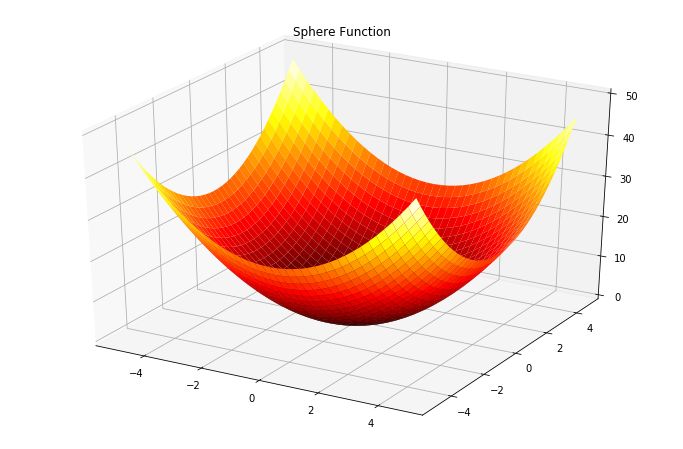

In [8]:
plot_3D_benchmark_function(objective_function_F1, np.arange(-5, 5, 0.25), np.arange(-5, 5, 0.25), 'Sphere Function')

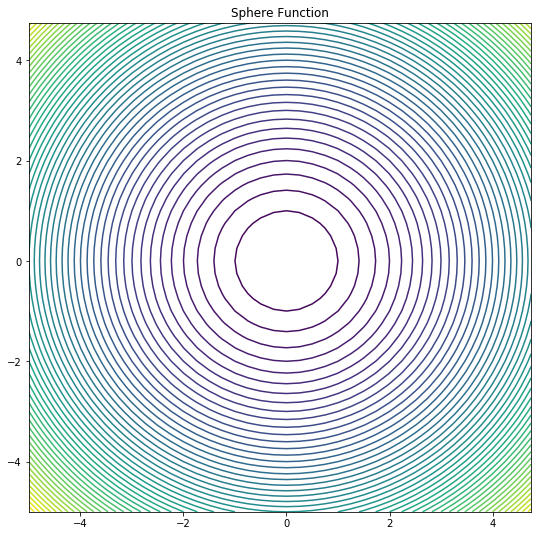

In [9]:
plot_contour_benchmark_function(objective_function_F1, np.arange(-5, 5, 0.25), np.arange(-5, 5, 0.25), 'Sphere Function')

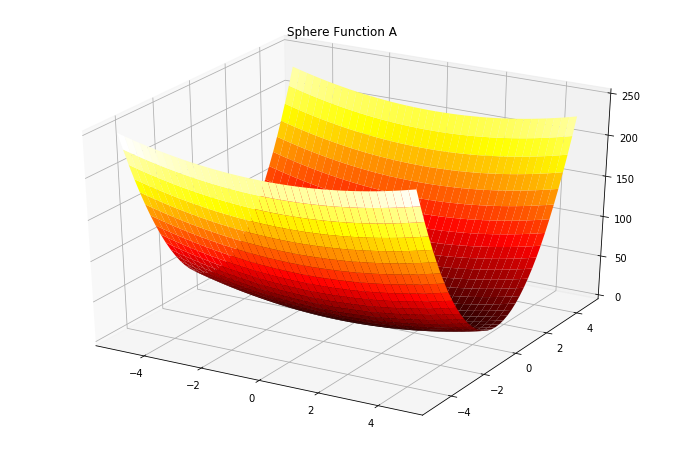

In [21]:
plot_3D_benchmark_function(objective_function_F1a, np.arange(-5, 5, 0.25), np.arange(-5, 5, 0.25), 'Sphere Function A')

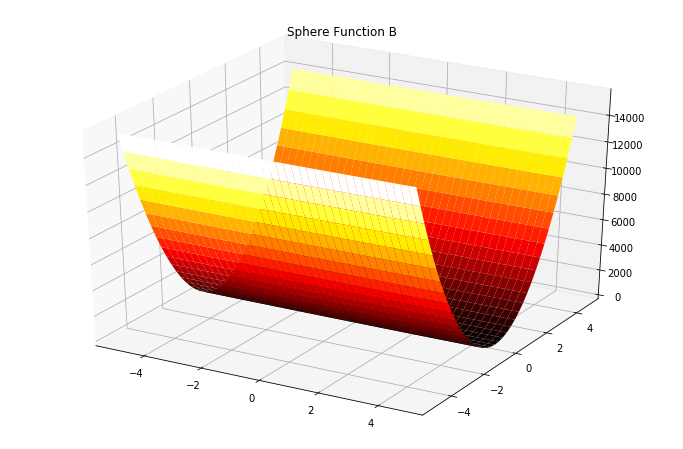

In [22]:
plot_3D_benchmark_function(objective_function_F1b, np.arange(-5, 5, 0.25), np.arange(-5, 5, 0.25), 'Sphere Function B')

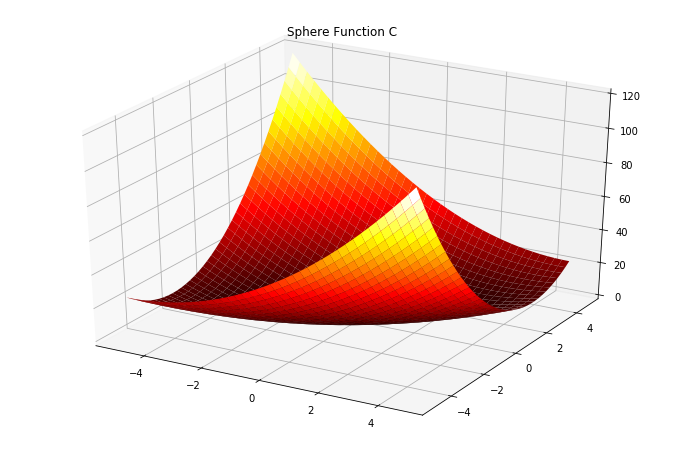

In [23]:
plot_3D_benchmark_function(objective_function_F1c, np.arange(-5, 5, 0.25), np.arange(-5, 5, 0.25), 'Sphere Function C')

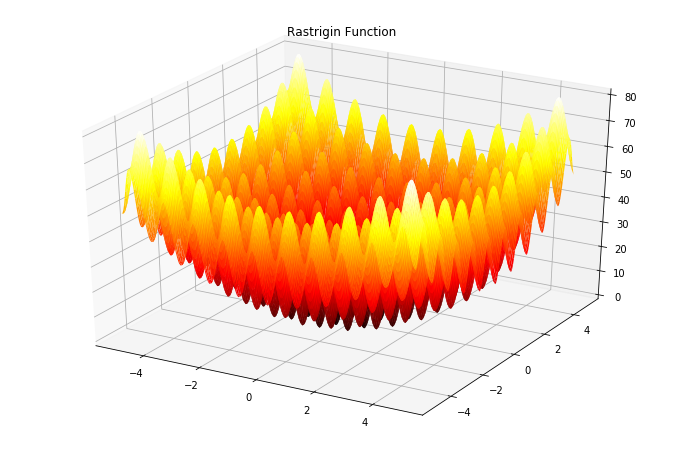

In [10]:
plot_3D_benchmark_function(objective_function_F6, np.arange(-5, 5, 0.05), np.arange(-5, 5, 0.05), 'Rastrigin Function')

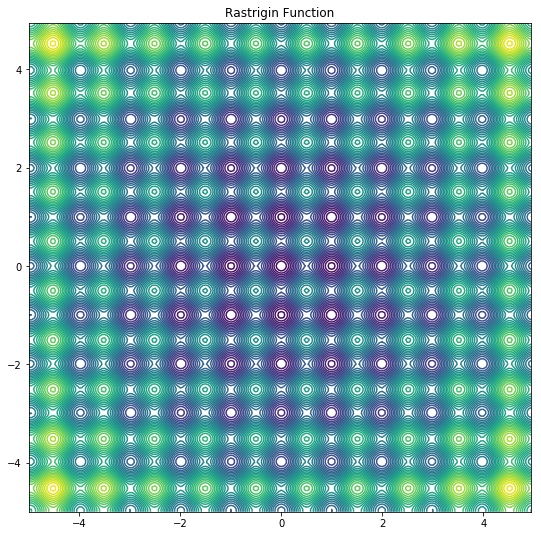

In [11]:
plot_contour_benchmark_function(objective_function_F6, np.arange(-5, 5, 0.05), np.arange(-5, 5, 0.05), 'Rastrigin Function')

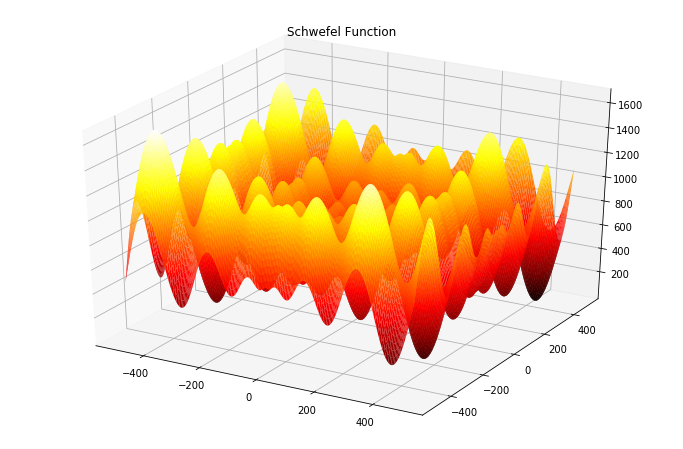

In [12]:
plot_3D_benchmark_function(objective_function_F7, np.arange(-500, 500, 5), np.arange(-500, 500, 5), 'Schwefel Function')

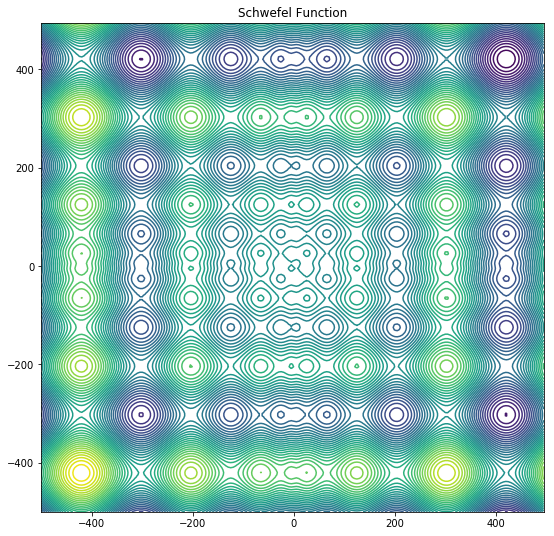

In [13]:
plot_contour_benchmark_function(objective_function_F7, np.arange(-500, 500, 5), np.arange(-500, 500, 5), 'Schwefel Function')

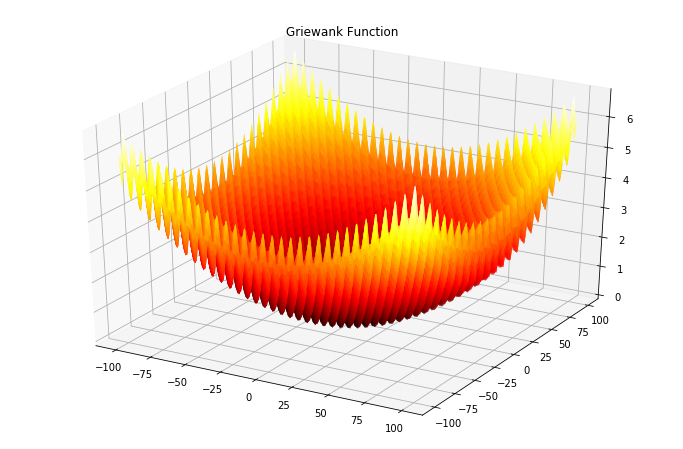

In [14]:
plot_3D_benchmark_function(objective_function_F8, np.arange(-100, 100, 0.5), np.arange(-100, 100, 0.5), 'Griewank Function')

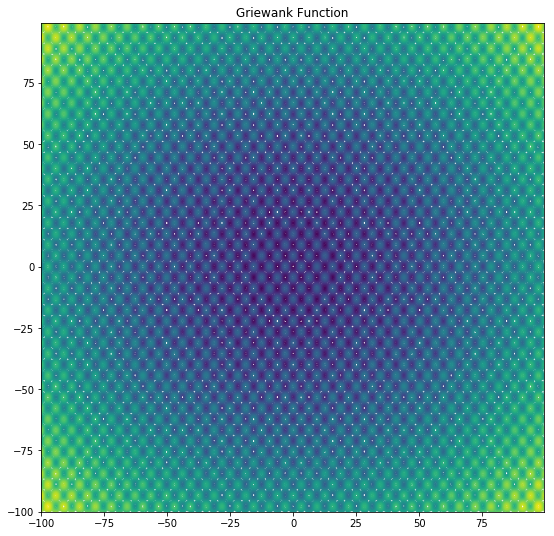

In [15]:
plot_contour_benchmark_function(objective_function_F8, np.arange(-100, 100, 0.5), np.arange(-100, 100, 0.5), 'Griewank Function')

## Przykładowe modele mutacji

In [582]:
def eigsorted(cov):
    '''
    Eigenvalues and eigenvectors of the covariance matrix.
    '''
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]


def cov_ellipse(cov, nstd=2.):
    """
    nstd=2 -> 95%
    nstd=1 -> 68%
    """
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[::-1, 0]))

    # Confidence level
    q = 2 * norm.cdf(nstd) - 1
    r2 = chi2.ppf(q, 2)

    width, height = 2 * np.sqrt(vals * r2)
    
    print('Ellipse axes: ({}, {}), Angle: {}'.format(width, height, theta))

    return matplot_Ellipse(
        xy=(1, 1),
        width=width,
        height=height,
        angle=theta,
        edgecolor='b',
        facecolor='None',
        linewidth=2,
        zorder=4,
    )
    

def plot_mutation_model(
        X, Y, Z,
        mutations,
        title,
        original_individual,
        mutations_vals,
        original_val,
        covariance_matrix=None,
        **kwargs
    ):
    
    mutations_mean = mutations_vals.mean()
    mutations_best = mutations_vals.max()
    better_mutations = np.where(mutations_vals > original_val)[0].shape[0]

    fig = plt.figure(figsize=(9, 9))

    # Plot ellipse
    plot_ellipse = 0

    if covariance_matrix is not None:
        e = cov_ellipse(covariance_matrix)
        ax = fig.add_subplot(111, aspect='equal')
        ax.add_artist(e)
        e.set_clip_box(ax.bbox)
        
    # Plot mutations
    plt.contour(X, Y, Z, 50)
    plt.plot(mutations[:, 0], mutations[:, 1], 'ro')
    plt.plot(original_individual[0, 0], original_individual[0, 1], 'k*', markersize=24)
    plt.title(title)
    plt.show()

    # Print stats
    print('Number of better mutations: {}'.format(better_mutations))
    print('Mutations mean: {}'.format(mutations_mean))
    print('Mutations best: {}'.format(mutations_best))
    print('Original individual: {}'.format(original_val))

    # Plot histogram
    plt.figure(figsize=(10,4))
    plt.hist(mutations_vals, bins=20)
    plt.plot(original_val, 1, 'k|', markersize=24)
    plt.title('Mutation values histogram')
    plt.show()


def calc_mutation_model(
        objective_function,
        domain_X,
        domain_Y,
        mutations,
        original_individual=np.array([[1, 1]]),
        covariance_matrix=None,
    ):
    X, Y = np.meshgrid(domain_X, domain_Y)
    Z = - objective_function(
        np.vstack([X.ravel(), Y.ravel()]).T
    ).reshape(X.shape[0], X.shape[1])

    original_val = objective_function(original_individual)[0]
    mutations_vals = objective_function(mutations)

    return {
        'X': X,
        'Y': Y,
        'Z': Z,
        'mutations': mutations,
        'original_individual': original_individual,
        'original_val': original_val,
        'mutations_vals': mutations_vals,
        'covariance_matrix': covariance_matrix,
    }


### Przykład 1:

$x_i = x_i + \varepsilon_i$, gdzie $\varepsilon_i$ ma rozkład normalny $\mathcal{N}(0, \sigma^2)$, zaś $\sigma$ jest taka sama dla wszystkich $i = 1, 2, \ldots, d$

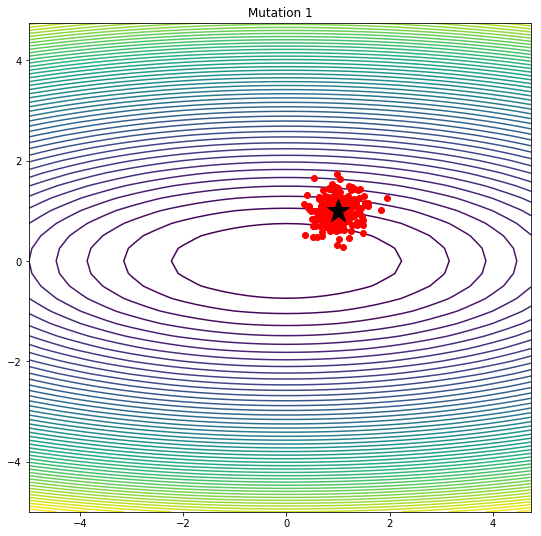

Number of better mutations: 129
Mutations mean: -10.4113120815
Mutations best: -1.86845103225
Original individual: -10


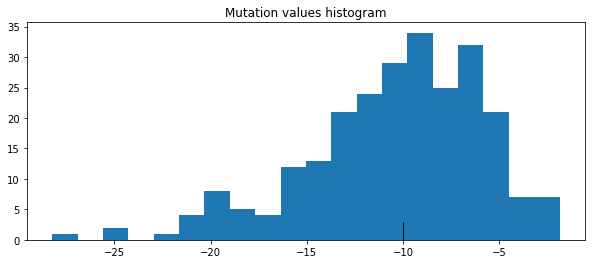

In [583]:
N = 250
d = 2
original_individual=np.array([[1, 1]])

sigma = 0.25
mutations = original_individual + sigma * np.random.randn(N, d)

params = {
    'objective_function': objective_function_F1a,
    'domain_X': np.arange(-5, 5, 0.25),
    'domain_Y': np.arange(-5, 5, 0.25),
    'mutations': mutations,
}

results = calc_mutation_model(**params)
plot_mutation_model(title='Mutation 1', **results)

### Przykład 2:

$x_i = x_i + \varepsilon_i$, gdzie $\varepsilon_i$ ma rozkład normalny $\mathcal{N}(0, \sigma_i^2)$, zaś $\sigma_i$ może być różna dla różnych $i = 1, 2, \ldots, d$

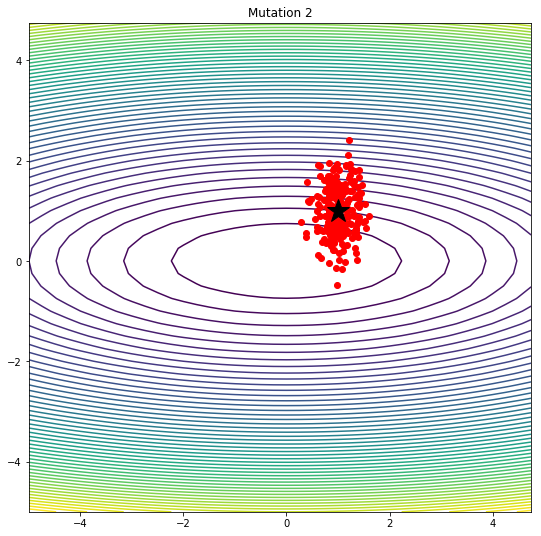

Number of better mutations: 127
Mutations mean: -12.1522494698
Mutations best: -0.47337099858
Original individual: -10


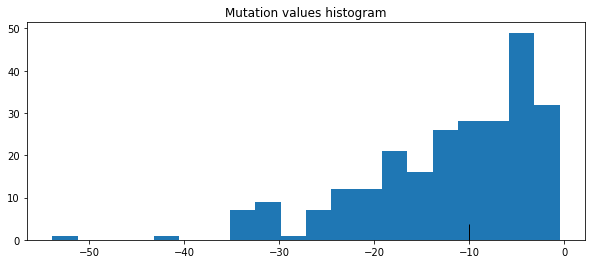

In [584]:
N = 250
d = 2
original_individual=np.array([[1, 1]])

sigma = np.array([0.25, 0.5])
mutations = original_individual + sigma * np.random.randn(N, d)

params = {
    'objective_function': objective_function_F1a,
    'domain_X': np.arange(-5, 5, 0.25),
    'domain_Y': np.arange(-5, 5, 0.25),
    'mutations': mutations,
}

results = calc_mutation_model(**params)
plot_mutation_model(title='Mutation 2', **results)

### Przykład 3:

$\mathbf{x} = \mathbf{x} + \boldsymbol{\varepsilon}$, gdzie $\boldsymbol{\varepsilon}$ ma wielowymiarowy rozkład normalny $\mathcal{N}(\mathbf{0}, \boldsymbol{\Sigma})$

Ellipse axes: (4.02239289314, 1.53641736907), Angle: 58.2825255885


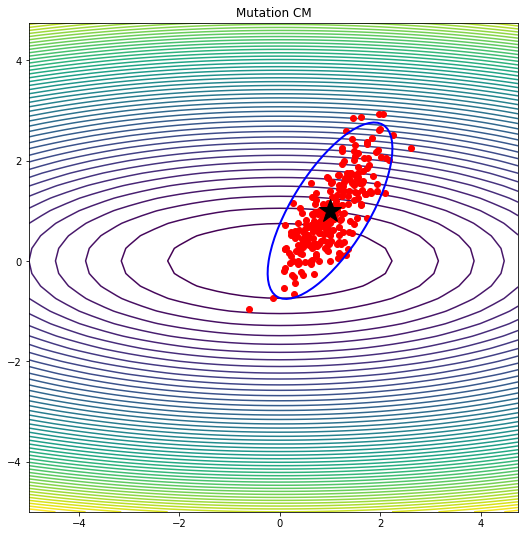

Number of better mutations: 143
Mutations mean: -14.6774765657
Mutations best: -0.0563037946276
Original individual: -10


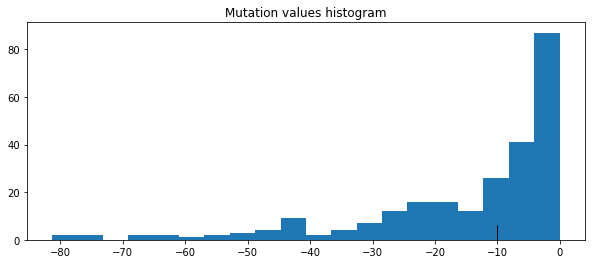

In [585]:
N = 250
d = 2
original_individual=np.array([[1, 1]])
# c :: [-0.35, 0.35]
# rozkład Choleskiego macierzy kowariancji Σ = AAT,
# X = A Z + µ,
# gdzie Z to zmienna losowa o standardowym rozkładzie normalnym

S = np.array([[0.25, 0.25],[0.25, 0.5]])
mutations = original_individual + np.dot(np.random.randn(N, d), np.linalg.cholesky(S).T)

params = {
    'objective_function': objective_function_F1a,
    'domain_X': np.arange(-5, 5, 0.25),
    'domain_Y': np.arange(-5, 5, 0.25),
    'mutations': mutations,
    'covariance_matrix': S,
}

results = calc_mutation_model(**params)
plot_mutation_model(title='Mutation CM', **results)

Ellipse axes: (3.63693412331, 2.3049800653), Angle: 70.670095873


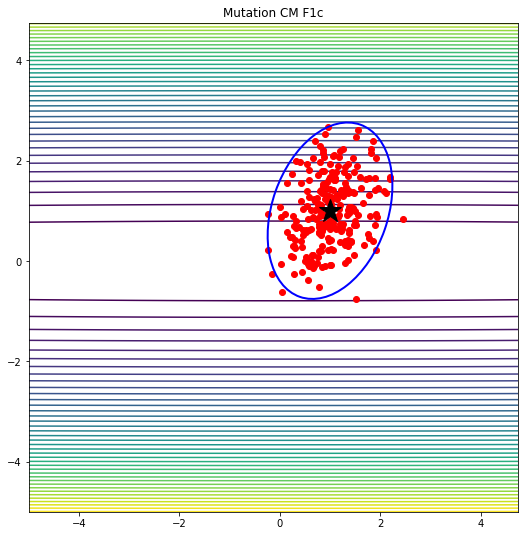

Number of better mutations: 129
Mutations mean: -907.809088457
Mutations best: -0.260976461089
Original individual: -626


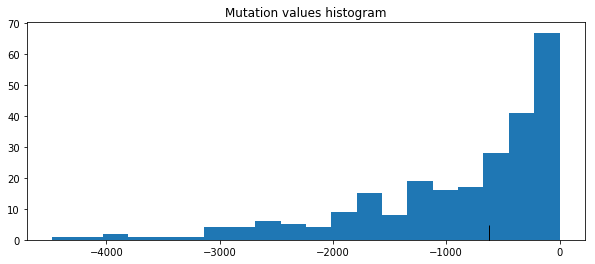

In [586]:
N = 250
d = 2
original_individual=np.array([[1, 1]])

S = np.array([[0.25, 0.25],[0.1, 0.5]])
mutations = original_individual + np.dot(np.random.randn(N, d), np.linalg.cholesky(S).T)

params = {
    'objective_function': objective_function_F1b,
    'domain_X': np.arange(-5, 5, 0.25),
    'domain_Y': np.arange(-5, 5, 0.25),
    'mutations': mutations,
    'covariance_matrix': S,
}

results = calc_mutation_model(**params)
plot_mutation_model(title='Mutation CM F1c', **results)

Ellipse axes: (3.8859209847, 1.8546808403), Angle: 61.002691604


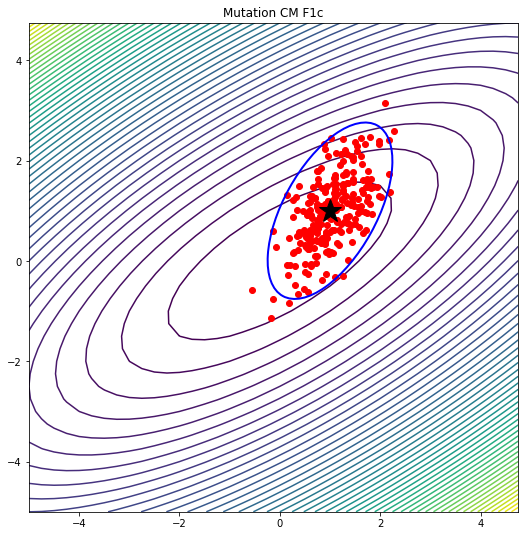

Number of better mutations: 98
Mutations mean: -1.83539802133
Mutations best: -0.0350908919075
Original individual: -1


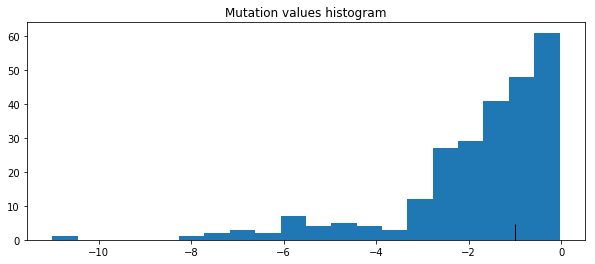

In [587]:
N = 250
d = 2
original_individual=np.array([[1, 1]])

S = np.array([[0.25, 0.25],[0.2, 0.5]])
mutations = original_individual + np.dot(np.random.randn(N, d), np.linalg.cholesky(S).T)

params = {
    'objective_function': objective_function_F1c,
    'domain_X': np.arange(-5, 5, 0.25),
    'domain_Y': np.arange(-5, 5, 0.25),
    'mutations': mutations,
    'covariance_matrix': S,
}

results = calc_mutation_model(**params)
plot_mutation_model(title='Mutation CM F1c', **results)

Ellipse axes: (4.20777414516, 1.43905334274), Angle: 54.2174744115


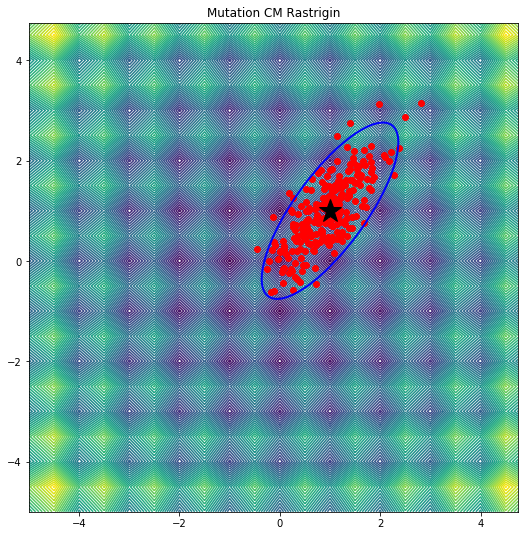

Number of better mutations: 1
Mutations mean: -22.6280542288
Mutations best: -0.395730762082
Original individual: -2.0


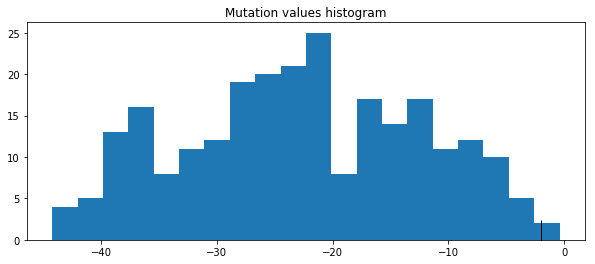

In [588]:
N = 250
d = 2
original_individual=np.array([[1, 1]])

S = np.array([[0.3, 0.25],[0.3, 0.5]])
mutations = original_individual + np.dot(np.random.randn(N, d), np.linalg.cholesky(S).T)

params = {
    'objective_function': objective_function_F6,  # Rastrigin
    'domain_X': np.arange(-5, 5, 0.25),
    'domain_Y': np.arange(-5, 5, 0.25),
    'mutations': mutations,
    'original_individual': original_individual,
    'covariance_matrix': S,
}

results = calc_mutation_model(**params)
plot_mutation_model(title='Mutation CM Rastrigin', **results)

Ellipse axes: (4.7998529283, 1.70813464133), Angle: 66.255223539


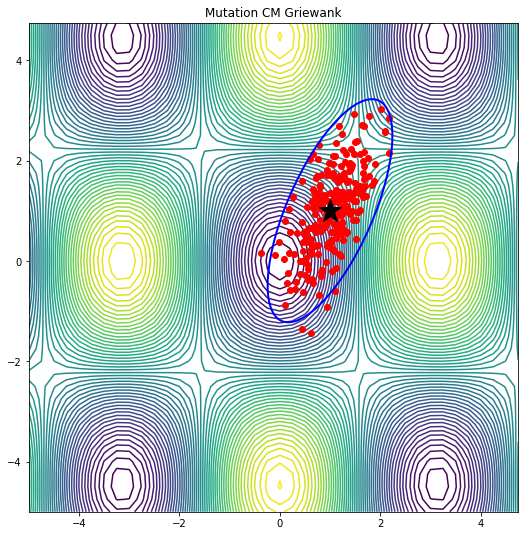

Number of better mutations: 104
Mutations mean: -0.641012315057
Mutations best: -0.00326262635565
Original individual: -0.589238091176


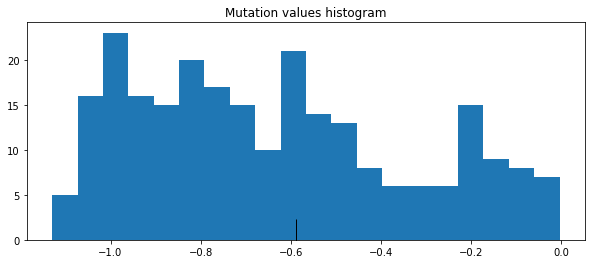

In [589]:
N = 250
d = 2
original_individual=np.array([[1, 1]])

S = np.array([[0.25, 0.25],[0.30, 0.8]])
mutations = original_individual + np.dot(np.random.randn(N, d), np.linalg.cholesky(S).T)

params = {
    'objective_function': objective_function_F8,  # Griewank
    'domain_X': np.arange(-5, 5, 0.25),
    'domain_Y': np.arange(-5, 5, 0.25),
    'mutations': mutations,
    'covariance_matrix': S,
}

results = calc_mutation_model(**params)
plot_mutation_model(title='Mutation CM Griewank', **results)

Ellipse axes: (6.71344575544, 1.37775571718), Angle: 56.8146888653


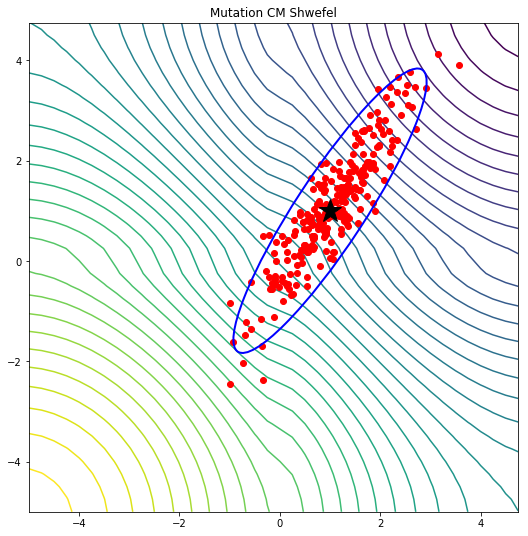

Number of better mutations: 129
Mutations mean: -836.048004199
Mutations best: -830.982751344
Original individual: -836.28285803


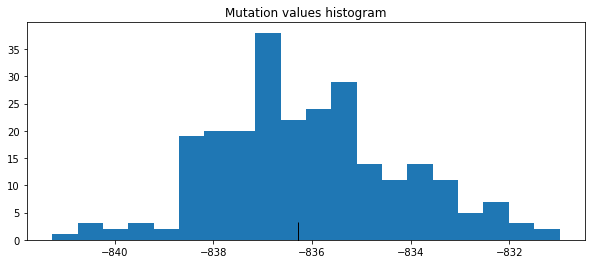

In [590]:
N = 250
d = 2
original_individual=np.array([[1, 1]])

S = np.array([[0.60, 0.25],[0.8, 1.3]])
mutations = original_individual + np.dot(np.random.randn(N, d), np.linalg.cholesky(S).T)

params = {
    'objective_function': objective_function_F7,  # Shwefel
    'domain_X': np.arange(-5, 5, 0.25),
    'domain_Y': np.arange(-5, 5, 0.25),
    'mutations': mutations,
    'covariance_matrix': S,
}

results = calc_mutation_model(**params)
plot_mutation_model(title='Mutation CM Shwefel', **results)

## Przykładowa strategia ewolucyjna

In [34]:
def es(objective_function,
       chromosome_length,
       population_size,
       number_of_iterations,
       number_of_offspring,
       number_of_parents,
       sigma,
       K=1.0,
       domain=(0, 100),
      ):
    time0 = time.time()

    tau=K/np.sqrt(2*d),
    tau_0=K/np.sqrt(2*np.sqrt(d)),

    best_solution = np.empty((1, chromosome_length))
    best_solution_objective_value = 0.00

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    log_best_sigmas = np.empty((number_of_iterations, chromosome_length))

    # generating an initial population
    current_population_solutions = np.random.uniform(domain[0], domain[1], (population_size, chromosome_length))

    current_population_sigmas = sigma * np.ones((population_size, chromosome_length))

    # evaluating the objective function on the current population
    current_population_objective_values = objective_function(current_population_solutions)
    
    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        parent_indices = np.random.choice(
            population_size,
            (number_of_offspring, number_of_parents),
            True,
            fitness_values
        ).astype(np.int64)

        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.zeros((number_of_offspring, chromosome_length))
        children_population_sigmas = np.zeros((number_of_offspring, chromosome_length))
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = \
                current_population_solutions[parent_indices[i, :], :].mean(axis=0)
            children_population_sigmas[i, :] = \
                current_population_sigmas[parent_indices[i, :], :].mean(axis=0)

        # mutating the children population by adding random gaussian noise
        children_population_sigmas = \
            children_population_sigmas * np.exp(tau * np.random.randn(number_of_offspring, chromosome_length) \
            + tau_0 * np.random.randn(number_of_offspring, 1))
        children_population_solutions = \
            children_population_solutions \
            + children_population_sigmas * np.random.randn(number_of_offspring, chromosome_length)

        # evaluating the objective function on the children population
        children_population_objective_values = objective_function(children_population_solutions)

        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = \
            np.hstack([current_population_objective_values, children_population_objective_values])
        current_population_solutions = \
            np.vstack([current_population_solutions, children_population_solutions])
        current_population_sigmas = \
            np.vstack([current_population_sigmas, children_population_sigmas])

        I = np.argsort(current_population_objective_values)[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_sigmas = current_population_sigmas[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[I[:population_size]]

        # recording some statistics
        if best_solution_objective_value < current_population_objective_values[0]:
            best_solution = current_population_solutions[0, :]
            best_solution_objective_value = current_population_objective_values[0]
        log_objective_values[t, :] = [
            current_population_objective_values.min(),
            current_population_objective_values.max(),
            current_population_objective_values.mean(),
            current_population_objective_values.std()
        ]
        log_best_solutions[t, :] = current_population_solutions[0, :]
        log_best_sigmas[t, :] = current_population_sigmas[0, :]

        if not t % (number_of_iterations/10) or t == number_of_iterations-1:
            print("Iteration %04d %14.8f: best = %0.8f, mean = %0.8f, std = %0.8f." % (
                t,
                time.time() - time0,
                log_objective_values[:t+1, 1].max(),
                log_objective_values[t, 2],
                log_objective_values[:t+1, 1].std(),
            ))

    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions, log_best_sigmas

In [391]:
def run_es(obj_function, d, N, T, sigma=50.0, K=1.0, domain=(0, 100)):
    best_objective_value, \
    best_chromosome, \
    history_objective_values, \
    history_best_chromosome, \
    history_best_sigmas = es(
        objective_function=obj_function,
        chromosome_length=d,
        population_size=N,
        number_of_iterations=T,
        number_of_offspring=2*N,
        number_of_parents=2,
        sigma=sigma,
        K=K,
        domain=domain,
    )

    plt.figure(figsize=(18, 4))
    plt.plot(history_objective_values[:, 0], 'r-')
    plt.plot(history_objective_values[:, 1], 'r-')
    plt.plot(history_objective_values[:, 2], 'r-')
    plt.xlabel('iteration')
    plt.ylabel('objective function value')
    plt.title('min/avg/max objective function values')
    plt.show()

    plt.figure(figsize=(18, 4))
    plt.plot(history_best_sigmas, 'r-')
    plt.xlabel('iteration')
    plt.ylabel('sigma value')
    plt.title('best sigmas')
    plt.show()

### Działanie strategii ewolucyjnej dla funkcji sferycznej F1

Iteration 0000     0.16100478: best = -5882.81112128, mean = -26688.26233075, std = 0.00000000.
Iteration 0010     1.60387087: best = -77.54042729, mean = -338.91044430, std = 2090.85471026.
Iteration 0020     3.03042579: best = -0.70704995, mean = -2.49504594, std = 1778.88896894.
Iteration 0030     4.46449280: best = -0.00495750, mean = -0.02357459, std = 1535.94274011.
Iteration 0040     5.89785790: best = -0.00002394, mean = -0.00018056, std = 1366.45118179.
Iteration 0050     7.32630396: best = -0.00000029, mean = -0.00000133, std = 1241.71606894.
Iteration 0060     8.75975180: best = -0.00000000, mean = -0.00000001, std = 1145.43190630.
Iteration 0070    10.18640995: best = -0.00000000, mean = -0.00000000, std = 1068.34818793.
Iteration 0080    11.61382079: best = -0.00000000, mean = -0.00000000, std = 1004.88561444.
Iteration 0090    13.04737592: best = -0.00000000, mean = -0.00000000, std = 951.47931031.
Iteration 0099    14.33795094: best = -0.00000000, mean = -0.00000000, std

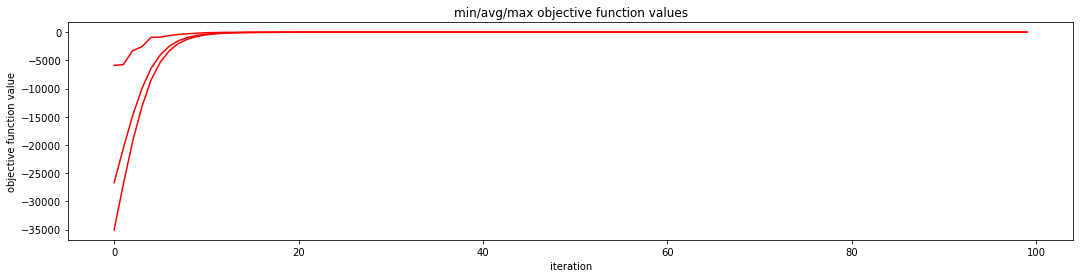

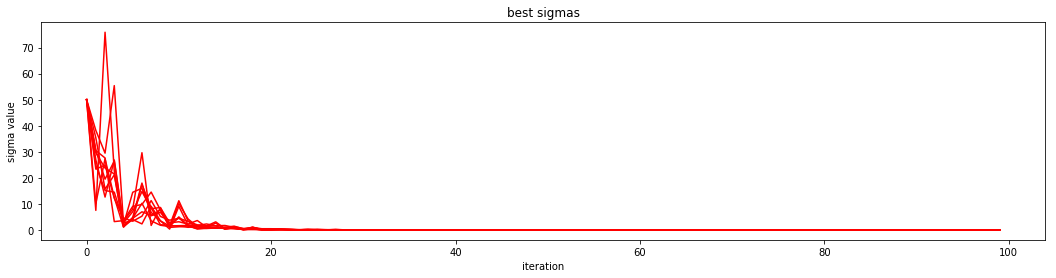

In [392]:
params = {
    'obj_function': objective_function_F1, 
    'd': 10,
    'N': 2000,
    'T': 100,
}
run_es(**params)

Iteration 0000 : best score = -100908.13053780, mean score = -159724.28541445.
Iteration 0024 : best score = -2113.90306062, mean score = -2964.72507918.
Iteration 0048 : best score = -57.49610199, mean score = -82.53937744.
Iteration 0072 : best score = -1.72157102, mean score = -2.48587115.
Iteration 0096 : best score = -0.06218142, mean score = -0.08794608.
Iteration 0120 : best score = -0.00208424, mean score = -0.00278886.
Iteration 0144 : best score = -0.00007270, mean score = -0.00009725.
Iteration 0168 : best score = -0.00000294, mean score = -0.00000414.
Iteration 0192 : best score = -0.00000011, mean score = -0.00000016.
Iteration 0216 : best score = -0.00000000, mean score = -0.00000001.
Iteration 0239 : best score = -0.00000000, mean score = -0.00000000.


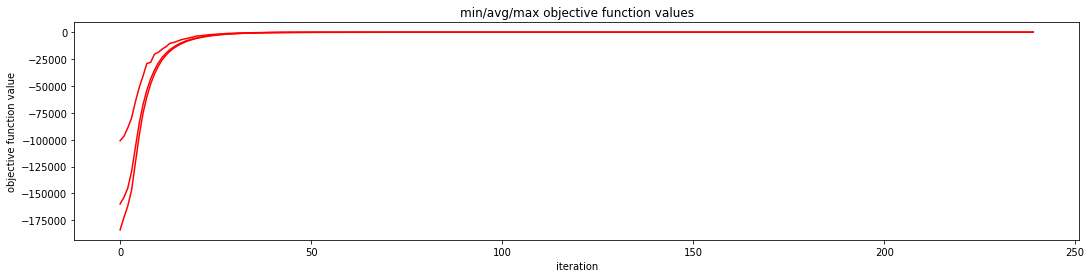

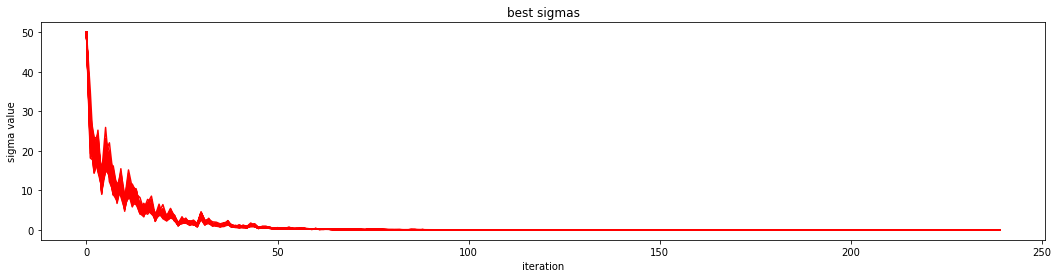

In [71]:
params = {
    'obj_function': objective_function_F1, 
    'd': 50,
    'N': 2000,
    'T': 240,
}
run_es(**params)

Iteration 0000 : best score = -242486.40945268, mean score = -325626.51697056.
Iteration 0040 : best score = -16001.47939662, mean score = -18838.89616338.
Iteration 0080 : best score = -2310.66696103, mean score = -2633.36212712.
Iteration 0120 : best score = -365.16615048, mean score = -407.24111974.
Iteration 0160 : best score = -58.75682142, mean score = -65.83481828.
Iteration 0200 : best score = -8.95182503, mean score = -9.96631496.
Iteration 0240 : best score = -1.11079455, mean score = -1.25365133.
Iteration 0280 : best score = -0.19708716, mean score = -0.22977888.
Iteration 0320 : best score = -0.03072095, mean score = -0.03318456.
Iteration 0360 : best score = -0.00508828, mean score = -0.00568931.
Iteration 0399 : best score = -0.00089065, mean score = -0.00097011.


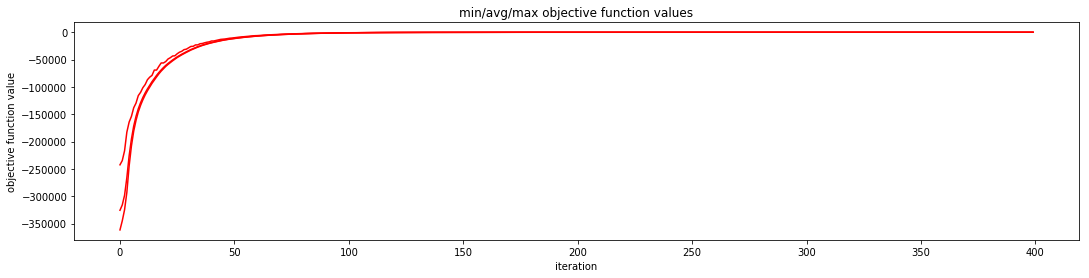

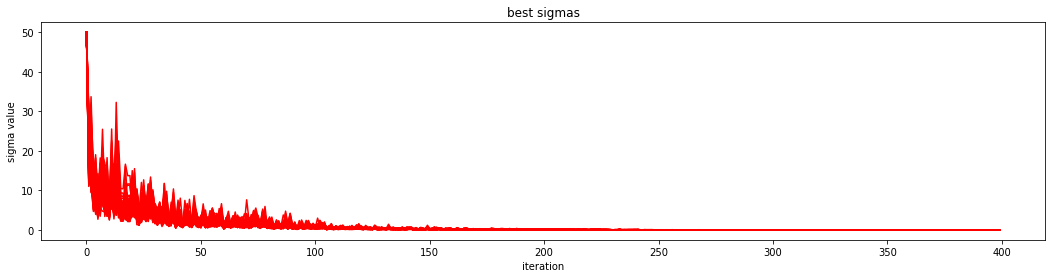

In [83]:
params = {
    'obj_function': objective_function_F1, 
    'd': 100,
    'N': 2000,
    'T': 400,
    'sigma': 50,
}
run_es(**params)

Iteration 0000 : best score = -220554.94906921, mean score = -277068.02854479.
Iteration 0040 : best score = -20154.46696528, mean score = -23144.60825375.
Iteration 0080 : best score = -2359.91643422, mean score = -2634.97359764.
Iteration 0120 : best score = -306.35384154, mean score = -337.91853966.
Iteration 0160 : best score = -43.10798850, mean score = -48.68316745.
Iteration 0200 : best score = -7.54357354, mean score = -8.37564798.
Iteration 0240 : best score = -1.05538565, mean score = -1.15395396.
Iteration 0280 : best score = -0.26271967, mean score = -0.28650944.
Iteration 0320 : best score = -0.04078758, mean score = -0.04362460.
Iteration 0360 : best score = -0.00509724, mean score = -0.00578324.
Iteration 0399 : best score = -0.00096963, mean score = -0.00109032.


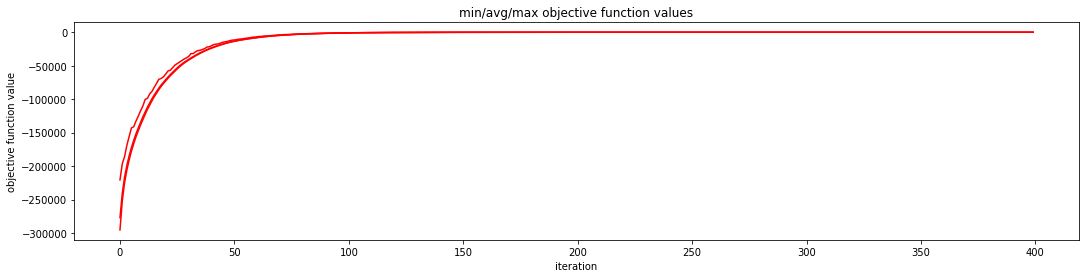

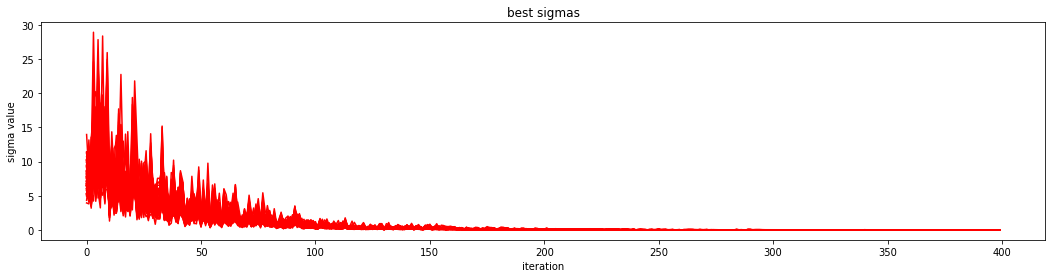

In [84]:
params = {
    'obj_function': objective_function_F1, 
    'd': 100,
    'N': 2000,
    'T': 400,
    'sigma': 10,
}
run_es(**params)

Iteration 0000 : best score = -203872.28113835, mean score = -265978.80948446.
Iteration 0040 : best score = -29169.31790618, mean score = -33438.26776924.
Iteration 0080 : best score = -3162.04187157, mean score = -3742.29330108.
Iteration 0120 : best score = -497.15300318, mean score = -569.06463816.
Iteration 0160 : best score = -87.33452614, mean score = -95.97426138.
Iteration 0200 : best score = -10.81588149, mean score = -12.48299391.
Iteration 0240 : best score = -1.16564595, mean score = -1.34582979.
Iteration 0280 : best score = -0.15289289, mean score = -0.17658081.
Iteration 0320 : best score = -0.02160677, mean score = -0.02433204.
Iteration 0360 : best score = -0.00408851, mean score = -0.00442554.
Iteration 0399 : best score = -0.00073120, mean score = -0.00079573.


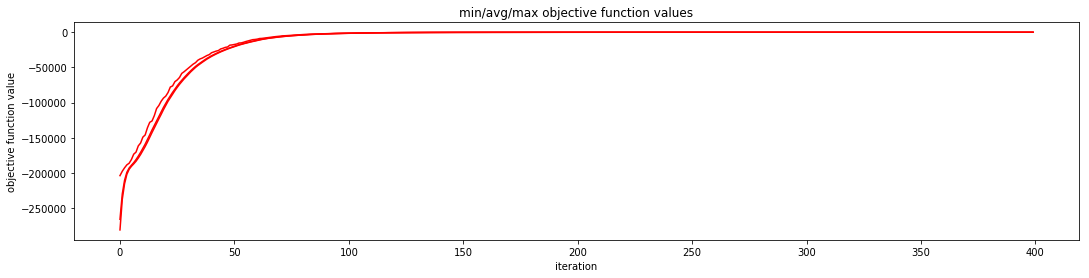

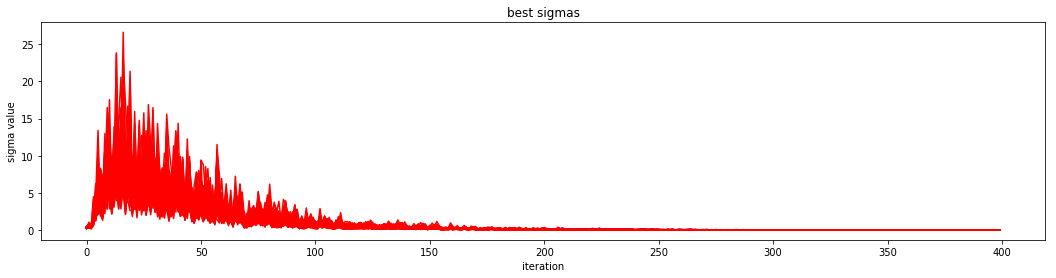

In [85]:
params = {
    'obj_function': objective_function_F1, 
    'd': 100,
    'N': 2000,
    'T': 400,
    'sigma': 1,
}
run_es(**params)

Iteration 0000 : best score = -196827.54707837, mean score = -330655.28902644.
Iteration 0040 : best score = -6638.02940247, mean score = -7933.98277875.
Iteration 0080 : best score = -279.70023294, mean score = -335.74432398.
Iteration 0120 : best score = -15.57291138, mean score = -18.55707438.
Iteration 0160 : best score = -0.99982328, mean score = -1.14559251.
Iteration 0200 : best score = -0.06443278, mean score = -0.07878588.
Iteration 0240 : best score = -0.00379248, mean score = -0.00439671.
Iteration 0280 : best score = -0.00022272, mean score = -0.00027679.
Iteration 0320 : best score = -0.00001335, mean score = -0.00001525.
Iteration 0360 : best score = -0.00000088, mean score = -0.00000100.
Iteration 0399 : best score = -0.00000006, mean score = -0.00000007.


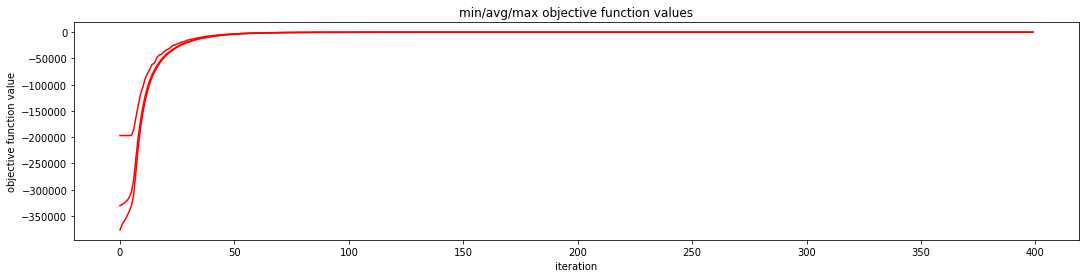

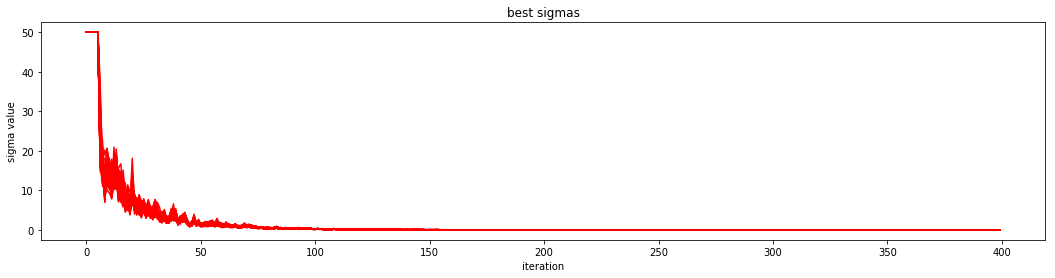

In [86]:
params = {
    'obj_function': objective_function_F1, 
    'd': 100,
    'N': 2000,
    'T': 400,
    'K': 0.5,
}
run_es(**params)

Iteration 0000 : best score = -220688.32626560, mean score = -310921.42063424.
Iteration 0040 : best score = -53414.09072750, mean score = -57829.85246398.
Iteration 0080 : best score = -14209.43590727, mean score = -15617.38556265.
Iteration 0120 : best score = -3949.58509399, mean score = -4189.73340780.
Iteration 0160 : best score = -1267.87227236, mean score = -1380.19763278.
Iteration 0200 : best score = -440.36479921, mean score = -470.94686911.
Iteration 0240 : best score = -228.82413385, mean score = -236.29866321.
Iteration 0280 : best score = -34.66366934, mean score = -41.30748255.
Iteration 0320 : best score = -18.42893765, mean score = -18.99270396.
Iteration 0360 : best score = -12.76774345, mean score = -12.99107992.
Iteration 0399 : best score = -11.35927141, mean score = -11.40205436.


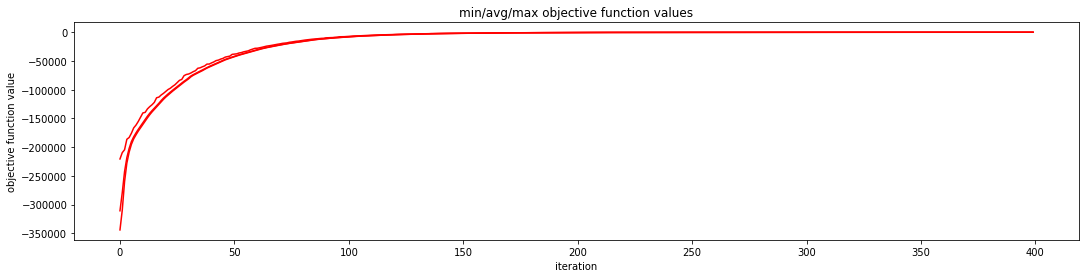

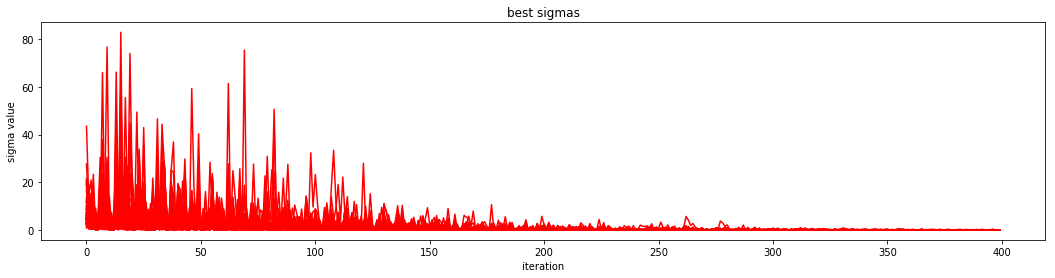

In [87]:
params = {
    'obj_function': objective_function_F1, 
    'd': 100,
    'N': 2000,
    'T': 400,
    'K': 3,
}
run_es(**params)

### Działanie strategii ewolucyjnej dla funkcji Rastrigina F6

Iteration 0000 : best score = -5690.88002747, mean score = -26570.54967244.
Iteration 0010 : best score = -90.46760907, mean score = -295.96795613.
Iteration 0020 : best score = -35.66668915, mean score = -75.63654710.
Iteration 0030 : best score = -24.11336461, mean score = -61.43755482.
Iteration 0040 : best score = -24.10776583, mean score = -54.83012483.
Iteration 0050 : best score = -3.91563905, mean score = -21.63366897.
Iteration 0060 : best score = -0.00765369, mean score = -0.05353288.
Iteration 0070 : best score = -0.00001442, mean score = -0.00011077.
Iteration 0080 : best score = -0.00000002, mean score = -0.00000018.
Iteration 0090 : best score = -0.00000000, mean score = -0.00000000.


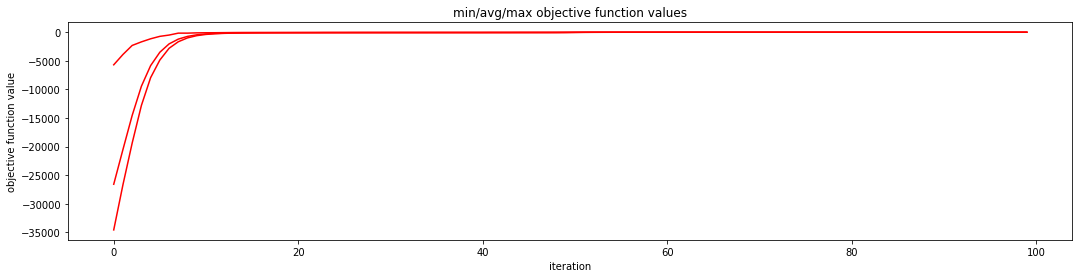

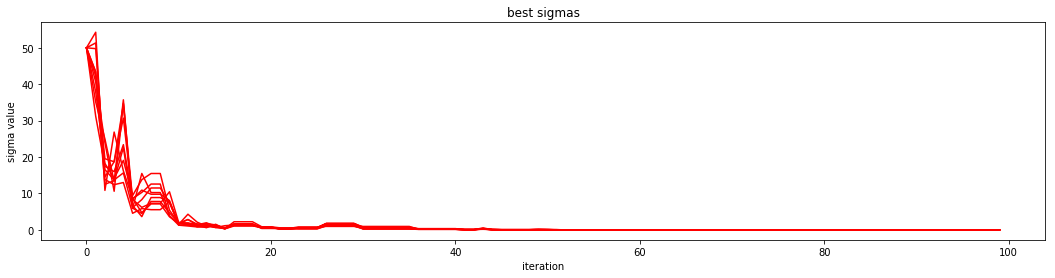

In [44]:
params = {
    'obj_function': objective_function_F6, 
    'd': 10,
    'N': 2000,
    'T': 100,
}
run_es(**params)

Iteration 0000     0.20134306: best = -28944.56062354, mean = -59186.61769337, std = 0.00000000.
Iteration 0160    25.05659318: best = -52.73277461, mean = -52.73277461, std = 3526.91173290.
Iteration 0320    50.19417000: best = -52.73277461, mean = -52.73277461, std = 2533.34918497.
Iteration 0480    75.06422210: best = -52.73277461, mean = -52.73277461, std = 2079.17977958.
Iteration 0640   100.03751707: best = -52.73277461, mean = -52.73277461, std = 1805.25537851.
Iteration 0800   124.90435719: best = -52.73277461, mean = -52.73277461, std = 1617.15457903.
Iteration 0960   149.89730000: best = -52.73277461, mean = -52.73277461, std = 1477.76533255.
Iteration 1120   174.97987819: best = -52.73277461, mean = -52.73277461, std = 1369.14448696.
Iteration 1280   200.28371906: best = -52.73277461, mean = -52.73277461, std = 1281.41860186.
Iteration 1440   225.72598004: best = -52.73277461, mean = -52.73277461, std = 1208.64717883.
Iteration 1599   250.82364511: best = -52.73277461, mean 

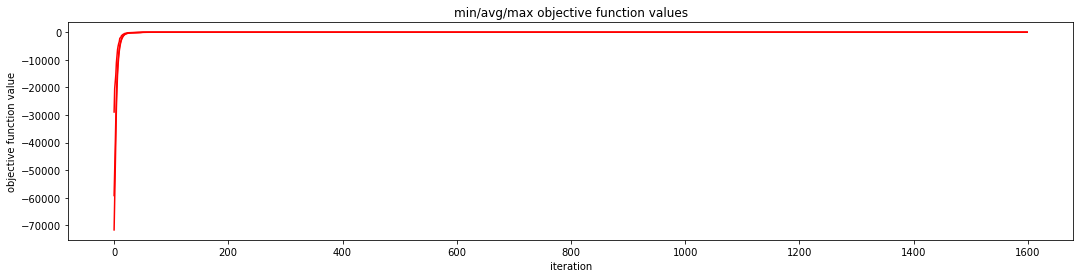

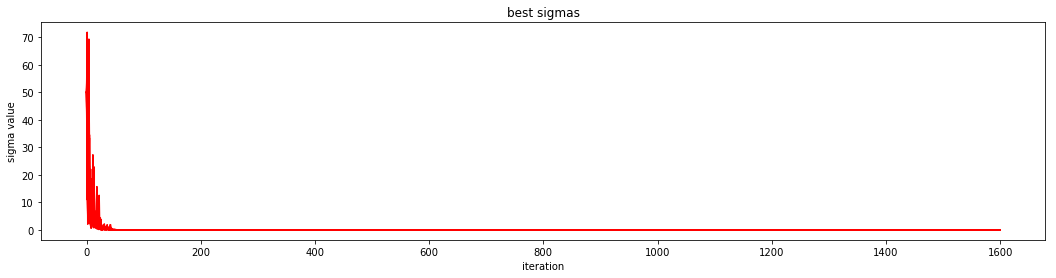

In [18]:
params = {
    'obj_function': objective_function_F6, 
    'd': 20,
    'N': 2000,
    'T': 1600,
    'sigma': 50,
}
run_es(**params)

Iteration 0000     0.14796495: best = -27965.76568617, mean = -47318.47627744, std = 0.00000000.
Iteration 0160    23.35473204: best = -39.79832702, mean = -39.79832702, std = 4397.91706974.
Iteration 0320    46.65791512: best = -39.79832702, mean = -39.79832702, std = 3174.87542914.
Iteration 0480    69.88196206: best = -39.79832702, mean = -39.79832702, std = 2609.88617353.
Iteration 0640    93.08475900: best = -39.79832702, mean = -39.79832702, std = 2267.83789231.
Iteration 0800   116.22751904: best = -39.79832702, mean = -39.79832702, std = 2032.49549006.
Iteration 0960   139.29847312: best = -39.79832702, mean = -39.79832702, std = 1857.88715137.
Iteration 1120   162.59867597: best = -39.79832702, mean = -39.79832702, std = 1721.70926996.
Iteration 1280   185.87003708: best = -39.79832702, mean = -39.79832702, std = 1611.66172960.
Iteration 1440   209.21462607: best = -39.79832702, mean = -39.79832702, std = 1520.33245760.
Iteration 1599   232.37134814: best = -39.79832702, mean 

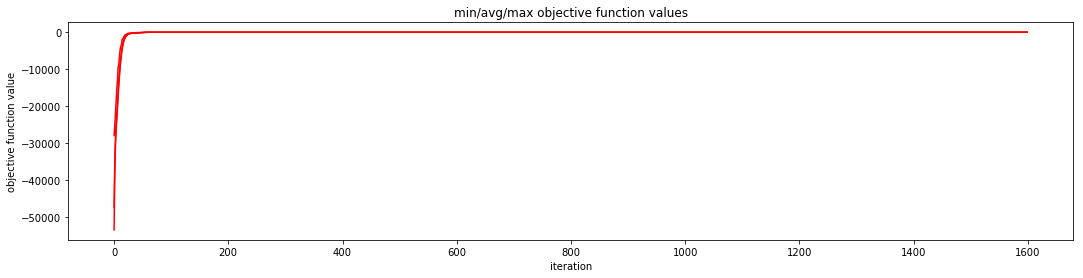

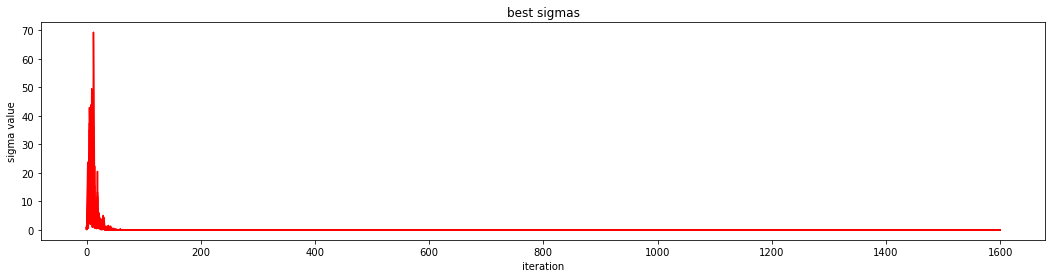

In [19]:
params = {
    'obj_function': objective_function_F6, 
    'd': 20,
    'N': 2000,
    'T': 1600,
    'sigma': 1,
}
run_es(**params)

In [ ]:
params = {
    'obj_function': objective_function_F6, 
    'd': 20,
    'N': 2000,
    'T': 1000,
    'sigma': 100,
}
run_es(**params)

Iteration 0000     0.16778779: best = -23875.65857217, mean = -60506.60490497, std = 0.00000000.
Iteration 0100    14.48353601: best = -347.55762050, mean = -411.07993576, std = 6719.77864121.
Iteration 0200    28.82895899: best = -132.25406887, mean = -148.45236174, std = 5426.06194615.
Iteration 0300    43.40108395: best = -54.12460958, mean = -59.27570781, std = 4614.10298054.
Iteration 0400    57.80916691: best = -14.17318968, mean = -15.16054394, std = 4079.15138414.
Iteration 0500    72.20243597: best = -0.02821204, mean = -0.03543432, std = 3693.94782902.
Iteration 0600    86.55954385: best = -0.00006816, mean = -0.00007931, std = 3399.75627979.
Iteration 0700   100.97969699: best = -0.00000022, mean = -0.00000028, std = 3165.74718746.
Iteration 0800   115.26117897: best = -0.00000000, mean = -0.00000000, std = 2973.98945020.
Iteration 0900   129.54382682: best = -0.00000000, mean = -0.00000000, std = 2813.19057673.
Iteration 0999   143.76638484: best = -0.00000000, mean = -0.00

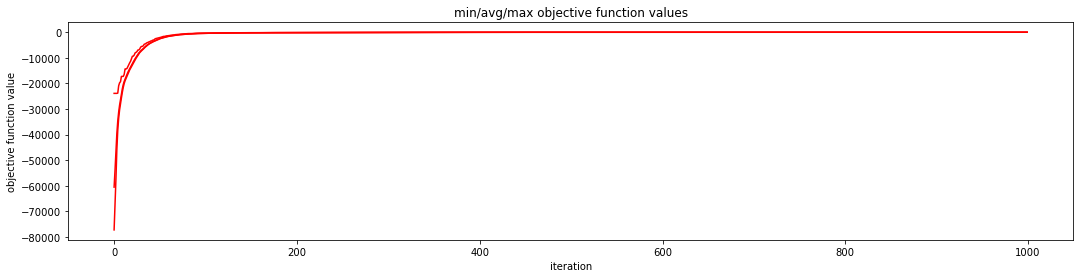

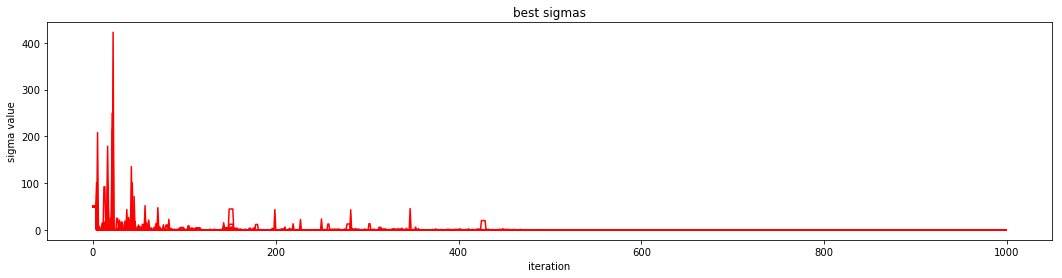

In [22]:
params = {
    'obj_function': objective_function_F6, 
    'd': 20,
    'N': 2000,
    'T': 1000,
    'sigma': 50,
    'K': 10,
}
run_es(**params)

Iteration 0000     0.16735101: best = -26043.58152922, mean = -60266.54411580, std = 0.00000000.
Iteration 0100    14.83319402: best = -75.40375568, mean = -129.19775598, std = 4130.05564429.
Iteration 0200    29.37927294: best = -15.91934491, mean = -15.91934491, std = 2983.50535653.
Iteration 0300    44.07317209: best = -15.91934491, mean = -15.91934491, std = 2453.39208402.
Iteration 0400    58.59672999: best = -15.91934491, mean = -15.91934491, std = 2132.21667310.
Iteration 0500    73.28375697: best = -15.91934491, mean = -15.91934491, std = 1911.14522589.
Iteration 0600    87.91639996: best = -15.91934491, mean = -15.91934491, std = 1747.08263928.
Iteration 0700   102.43212199: best = -15.91934491, mean = -15.91934491, std = 1619.10665752.
Iteration 0800   116.89353108: best = -15.91934491, mean = -15.91934491, std = 1515.67372531.
Iteration 0900   131.40869808: best = -15.91934491, mean = -15.91934491, std = 1429.82541843.
Iteration 0999   145.86901808: best = -15.91934491, mean

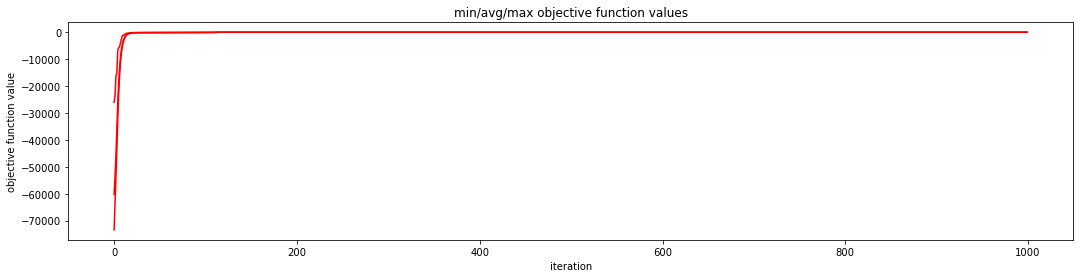

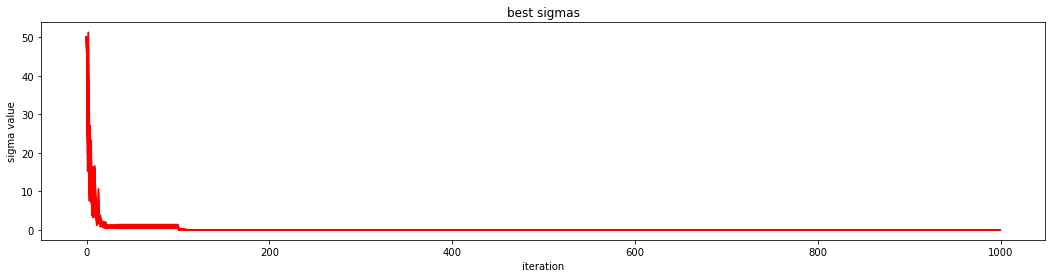

In [24]:
params = {
    'obj_function': objective_function_F6, 
    'd': 20,
    'N': 2000,
    'T': 1000,
    'sigma': 50,
    'K': 0.5,
}
run_es(**params)

Iteration 0000     0.25275803: best = -66833.13231153, mean = -126321.98253874, std = 0.00000000.
Iteration 0200    46.96281910: best = -928.32603229, mean = -1028.01079737, std = 17185.09312614.
Iteration 0400    93.69871593: best = -416.76874188, mean = -439.48891141, std = 13805.03607419.
Iteration 0600   140.72381711: best = -235.88604069, mean = -246.63324175, std = 11722.27696053.
Iteration 0800   187.52088809: best = -87.88912032, mean = -91.88554748, std = 10355.94447397.
Iteration 1000   234.17652512: best = -20.55122758, mean = -21.35170345, std = 9377.50602891.
Iteration 1200   280.28611803: best = -0.00897222, mean = -0.01032281, std = 8631.43722296.
Iteration 1400   326.19949698: best = -0.00003282, mean = -0.00003605, std = 8038.04350179.
Iteration 1600   372.48916101: best = -0.00000013, mean = -0.00000014, std = 7551.64061504.
Iteration 1800   418.52659512: best = -0.00000000, mean = -0.00000000, std = 7143.67805129.
Iteration 1999   464.52749801: best = -0.00000000, me

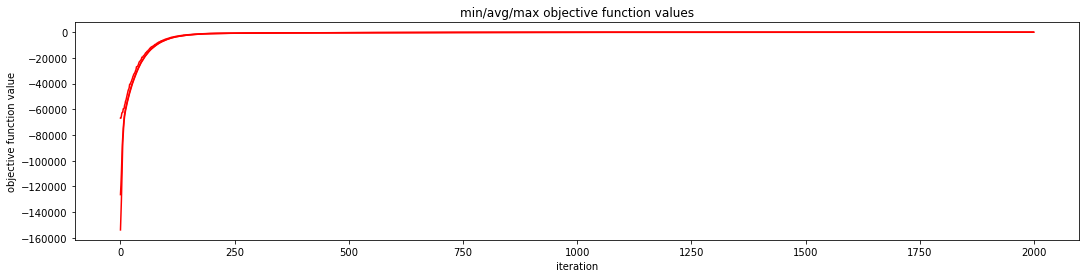

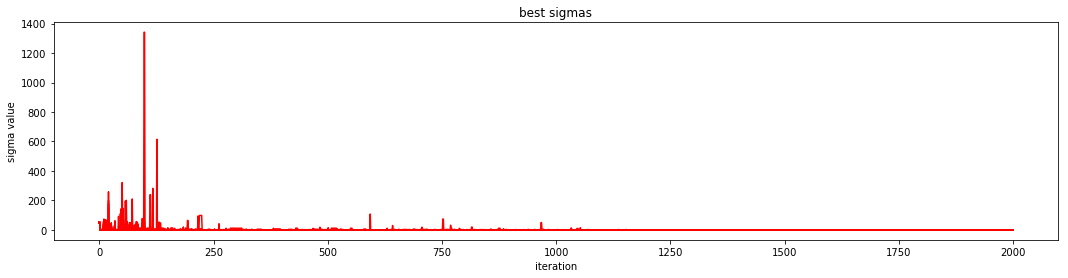

In [26]:
params = {
    'obj_function': objective_function_F6, 
    'd': 40,
    'N': 3000,
    'T': 2000,
    'sigma': 50,
    'K': 10,
}
run_es(**params)

Iteration 0000     0.30632687: best = -123283.30763467, mean = -193457.67073983, std = 0.00000000.
Iteration 0200    51.10085988: best = -4021.20814853, mean = -4239.25281917, std = 31897.10071529.
Iteration 0400   101.65075684: best = -991.19735897, mean = -1049.71893630, std = 27638.19267341.
Iteration 0600   151.94360781: best = -666.10758044, mean = -694.45842400, std = 23942.78048968.
Iteration 0800   202.26880193: best = -486.90998366, mean = -510.21196984, std = 21327.79629640.
Iteration 1000   252.64893389: best = -314.06392121, mean = -324.97864962, std = 19401.01830102.
Iteration 1200   302.89019990: best = -173.73811317, mean = -179.77682062, std = 17914.23264993.
Iteration 1400   353.20270801: best = -63.67995144, mean = -67.58281913, std = 16724.31092962.
Iteration 1600   403.47357392: best = -26.89224975, mean = -27.86081769, std = 15743.79261082.
Iteration 1800   453.37404990: best = -1.19299029, mean = -1.21620701, std = 14917.01882010.
Iteration 1999   502.71656585: be

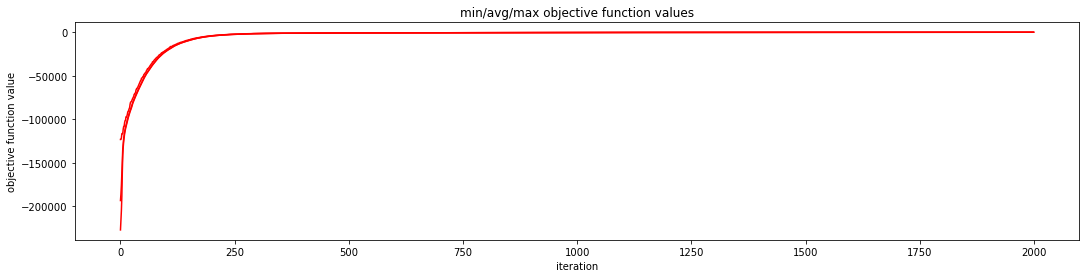

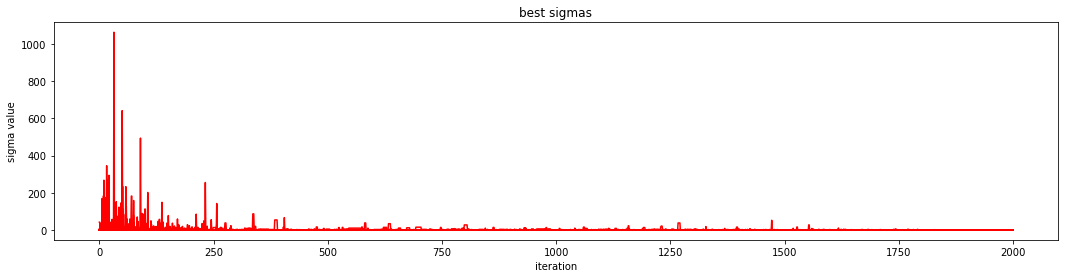

In [37]:
params = {
    'obj_function': objective_function_F6, 
    'd': 60,
    'N': 3000,
    'T': 2000,
    'sigma': 50,
    'K': 10,
}
run_es(**params)

### Działanie strategii ewolucyjnej dla funkcji Griewanka F8

Iteration 0000 : best score = -2.54143267, mean score = -7.59305265.
Iteration 0010 : best score = -0.67554100, mean score = -1.04923044.
Iteration 0020 : best score = -0.05719943, mean score = -0.31325744.
Iteration 0030 : best score = -0.00019973, mean score = -0.00115957.
Iteration 0040 : best score = -0.00000169, mean score = -0.00000745.
Iteration 0050 : best score = -0.00000001, mean score = -0.00000004.
Iteration 0060 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0070 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0080 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0090 : best score = 0.00000000, mean score = 0.00000000.


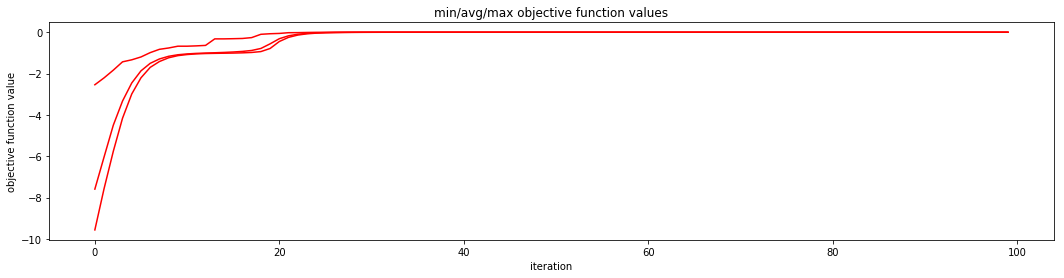

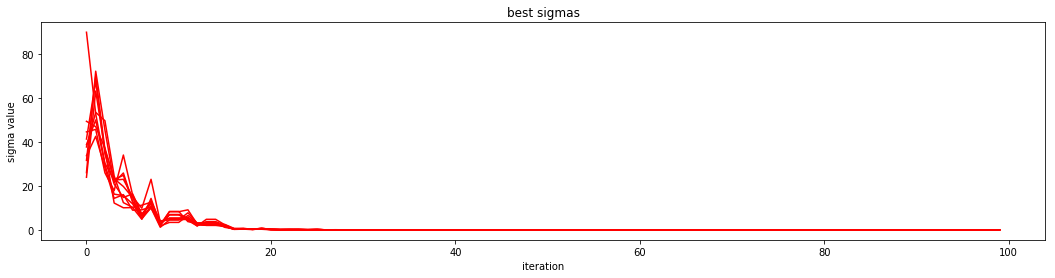

In [43]:
params = {
    'obj_function': objective_function_F8, 
    'd': 10,
    'N': 2000,
    'T': 100,
}
run_es(**params)

Iteration 0000     0.18299770: best = -62.49571856, mean = -82.04136117, std = 0.00000000.
Iteration 0030     4.07186079: best = -8.45164959, mean = -9.53201612, std = 14.92538922.
Iteration 0060     8.12264895: best = -2.42273297, mean = -2.67013164, std = 14.55911565.
Iteration 0090    12.11076450: best = -1.37307486, mean = -1.41876464, std = 13.35602693.
Iteration 0120    16.05302596: best = -1.10055928, mean = -1.11535726, std = 12.23799331.
Iteration 0150    20.48047972: best = -0.68825789, mean = -0.77216616, std = 11.31752292.
Iteration 0180    26.46786141: best = -0.34945167, mean = -0.37289122, std = 10.58882867.
Iteration 0210    30.52231932: best = -0.16957808, mean = -0.18184296, std = 9.98730193.
Iteration 0240    34.43879867: best = -0.05205587, mean = -0.05614064, std = 9.47743055.
Iteration 0270    38.22017670: best = -0.01805688, mean = -0.01974132, std = 9.03666133.
Iteration 0299    41.85984468: best = -0.00556071, mean = -0.00615216, std = 8.66209685.


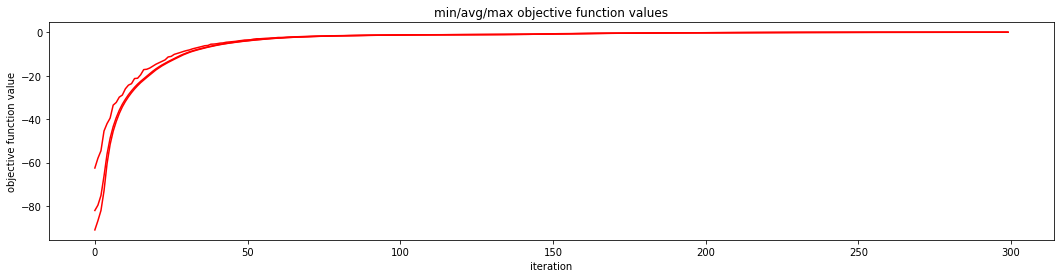

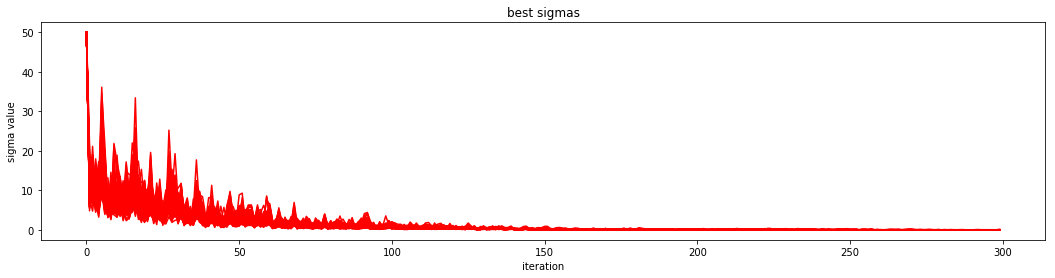

In [104]:
params = {
    'obj_function': objective_function_F8, 
    'd': 100,
    'N': 2000,
    'T': 300,
}
run_es(**params)

### Działanie strategii ewolucyjnej dla funkcji Shwefela F7

In [40]:
params = {
    'obj_function': objective_function_F7,
    'd': 10,
    'N': 2000,
    'T': 200,
    'domain': (-500, 500),
    'sigma': 0.1,
}
run_es(**params)

Iteration 0000     0.16134095: best = -1945.97856094, mean = -3602.36216720, std = 0.00000000.
Iteration 0020     2.92840695: best = -1931.69803154, mean = -2977.90807695, std = 3.52780007.
Iteration 0040     5.68212891: best = 38736.88450982, mean = 335.87958622, std = 6405.72993434.
Iteration 0060     8.41976404: best = 27016992792561044.00000000, mean = 1000614165320096.00000000, std = 3517412980420438.50000000.


KeyboardInterrupt: 

### Działanie strategii ewolucyjnej dla zmodyfikowanych funkcji Sferycznych F1{a, b, c}

Iteration 0000     0.21984601: best = -5.97881976, mean = -7202.44162251, std = 0.00000000.
Iteration 0003     0.79852796: best = -0.51742144, mean = -564.52757083, std = 2.73069916.
Iteration 0006     1.37105203: best = -0.03820170, mean = -53.43082410, std = 2.57178906.
Iteration 0009     1.94222403: best = -0.00190288, mean = -4.81570571, std = 2.32217875.
Iteration 0012     2.51469207: best = -0.00001940, mean = -0.43138462, std = 2.11462561.
Iteration 0015     3.08409309: best = -0.00001940, mean = -0.03784723, std = 1.94882292.
Iteration 0018     3.65663815: best = -0.00000086, mean = -0.00345236, std = 1.81470116.
Iteration 0021     4.22541213: best = -0.00000014, mean = -0.00032458, std = 1.70401987.
Iteration 0024     4.79886699: best = -0.00000005, mean = -0.00002569, std = 1.61093376.
Iteration 0027     5.36771607: best = -0.00000000, mean = -0.00000219, std = 1.53134826.
Iteration 0029     5.75289607: best = -0.00000000, mean = -0.00000041, std = 1.48431594.


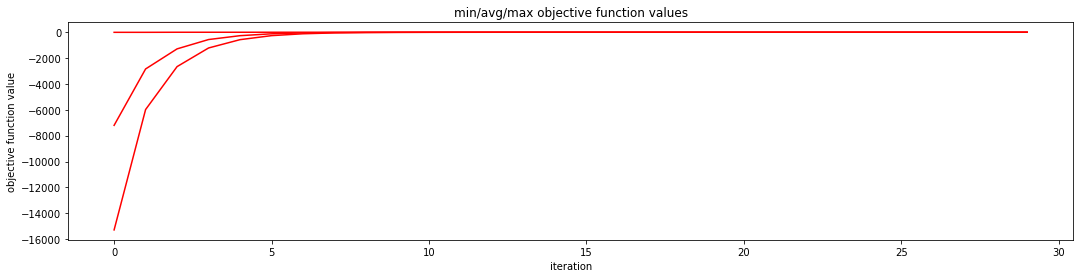

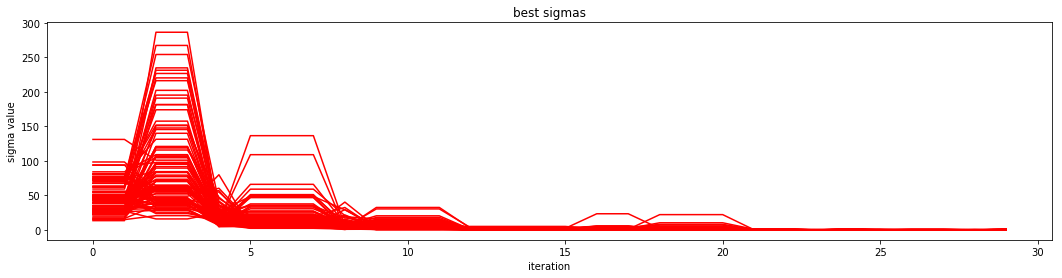

In [331]:
params = {
    'obj_function': objective_function_F1a,
    'd': 100,
    'N': 2000,
    'T': 30,
    'sigma': 50,
}
run_es(**params)

Iteration 0000     0.19996810: best = -2.09221580, mean = -230636.33922178, std = 0.00000000.
Iteration 0003     0.76845217: best = -2.09221580, mean = -9757.18442387, std = 0.00000000.
Iteration 0006     1.33869815: best = -2.09221580, mean = -1585.10027643, std = 0.00000000.
Iteration 0009     1.90647507: best = -0.57265670, mean = -237.18352785, std = 0.55364034.
Iteration 0012     2.47777414: best = -0.01563673, mean = -25.68270013, std = 0.86856067.
Iteration 0015     3.04420710: best = -0.00061751, mean = -2.12398845, std = 0.95464637.
Iteration 0018     3.61589217: best = -0.00010109, mean = -0.17702320, std = 0.97086143.
Iteration 0021     4.18560314: best = -0.00000694, mean = -0.01478173, std = 0.96127719.
Iteration 0024     4.75819921: best = -0.00000059, mean = -0.00130046, std = 0.94167340.
Iteration 0027     5.32634711: best = -0.00000003, mean = -0.00009509, std = 0.91834631.
Iteration 0029     5.70629907: best = -0.00000000, mean = -0.00001695, std = 0.90216510.


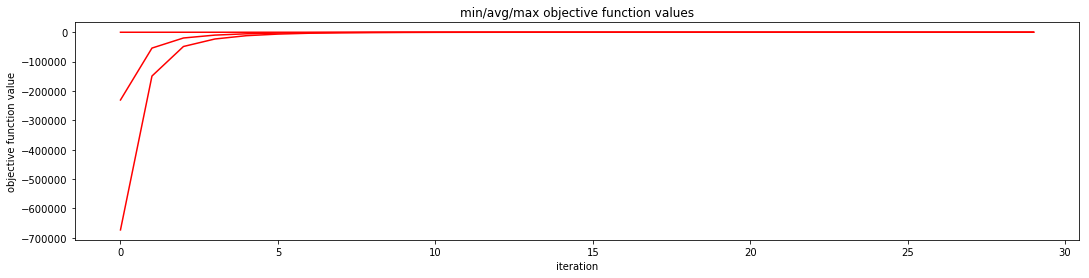

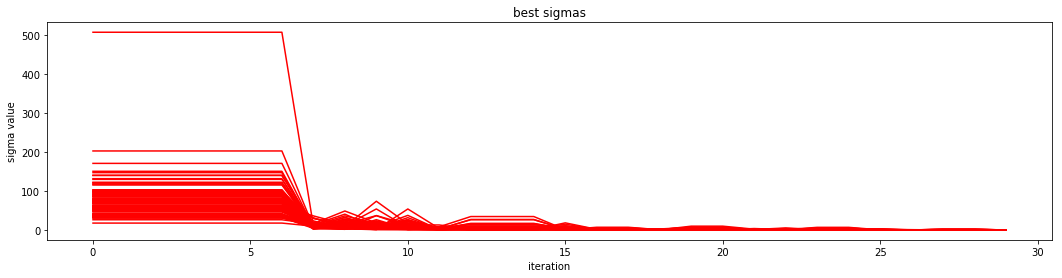

In [333]:
params = {
    'obj_function': objective_function_F1b,
    'd': 100,
    'N': 2000,
    'T': 30,
    'sigma': 50,
}
run_es(**params)

Iteration 0000     0.22155809: best = -3.68244974, mean = -1854.00300654, std = 0.00000000.
Iteration 0003     0.79587388: best = -0.08987120, mean = -186.53924211, std = 1.53859856.
Iteration 0006     1.36831307: best = -0.00779879, mean = -20.63004587, std = 1.40890150.
Iteration 0009     1.92543101: best = -0.00222784, mean = -2.13468018, std = 1.25235750.
Iteration 0012     2.49352908: best = -0.00012563, mean = -0.19808629, std = 1.13202272.
Iteration 0015     3.06182599: best = -0.00000625, mean = -0.01744748, std = 1.03891284.
Iteration 0018     3.63288307: best = -0.00000175, mean = -0.00151532, std = 0.96483080.
Iteration 0021     4.19937396: best = -0.00000003, mean = -0.00013491, std = 0.90430308.
Iteration 0024     4.77000308: best = -0.00000001, mean = -0.00001192, std = 0.85373651.
Iteration 0027     5.33768797: best = -0.00000000, mean = -0.00000103, std = 0.81071014.
Iteration 0029     5.71751690: best = -0.00000000, mean = -0.00000020, std = 0.78536171.


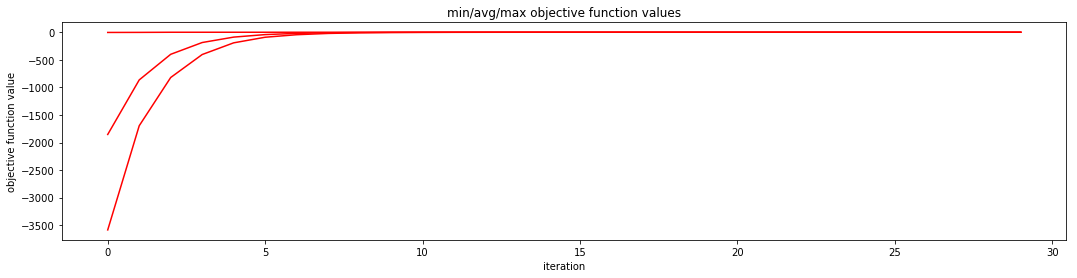

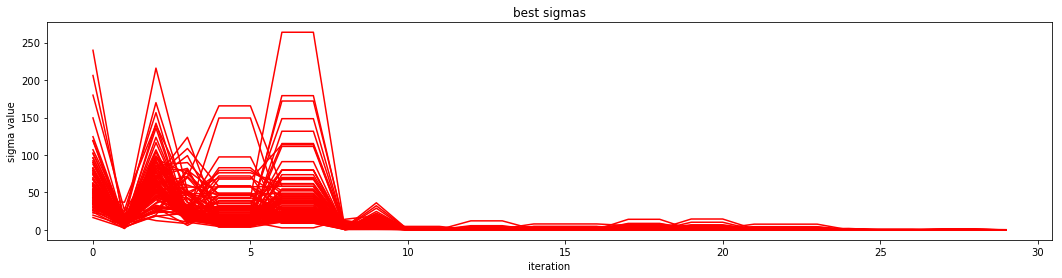

In [334]:
params = {
    'obj_function': objective_function_F1c,
    'd': 100,
    'N': 2000,
    'T': 30,
    'sigma': 50,
}
run_es(**params)